# Tune context window

## Get balanced dataset of at least 2k instances from dev

In [1]:
import pandas as pd

# Load
dev = pd.read_pickle('/usr2/mamille2/fanfiction-project/data/features/relationship_prediction_assertion_dev.pkl')

In [2]:
# Remove problem row/s
dev.columns

Index(['fic_id', 'pairing', 'pairing_embedding_unigrams_assertions_local_5',
       'pairing_embedding_unigrams_assertions_local_10',
       'pairing_embedding_unigrams_assertions_local_25',
       'pairing_embedding_unigrams_assertions_local_50', 'relationship',
       'selected_relationships', 'is_romantic', 'is_canon', 'is_mm'],
      dtype='object')

In [3]:
# Remove problem row/s
print(len(dev))
dev = dev.loc[dev['pairing_embedding_unigrams_assertions_local_10'].map(lambda x: x.shape==(1,170998)), :]
len(dev)

6503


6501

In [4]:
# Pairing distribution
pairing_counts = dev['pairing'].value_counts().to_dict()
pairing_counts

{('harry', 'hermione'): 1716,
 ('harry', 'ron'): 1471,
 ('draco', 'harry'): 1349,
 ('hermione', 'ron'): 1184,
 ('draco', 'hermione'): 449,
 ('ginny', 'harry'): 332}

In [5]:
min_split = min(pairing_counts.values())
min_split * 6

1992

In [6]:
# Balance
balanced_dev = pd.DataFrame(columns=dev.columns)

for pairing in pairing_counts:
    
    n_sample = min_split
    pairing_rows = dev[dev['pairing']==pairing].sample(n_sample)

    balanced_dev = pd.concat([balanced_dev, pairing_rows])
    
print(len(balanced_dev))
print(balanced_dev.columns)
print(balanced_dev['pairing'].value_counts())

1992
Index(['fic_id', 'pairing', 'pairing_embedding_unigrams_assertions_local_5',
       'pairing_embedding_unigrams_assertions_local_10',
       'pairing_embedding_unigrams_assertions_local_25',
       'pairing_embedding_unigrams_assertions_local_50', 'relationship',
       'selected_relationships', 'is_romantic', 'is_canon', 'is_mm'],
      dtype='object')
(harry, hermione)    332
(hermione, ron)      332
(ginny, harry)       332
(draco, hermione)    332
(harry, ron)         332
(draco, harry)       332
Name: pairing, dtype: int64


In [17]:
# train/test split

from IPython.core.debugger import set_trace

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import scipy

train, test = train_test_split(balanced_dev, test_size=0.2, random_state=9)
print(len(train))
print(len(test))

feature_sets = [f'pairing_embedding_unigrams_assertions_local_{i}' for i in [5,10,25,50]]
predictions = ['is_romantic', 'is_canon', 'is_mm']

X_train, y_train = {}, {}
X_test, y_test = {}, {}

for feature_set in feature_sets:
    X_train[feature_set] = scipy.sparse.vstack(train[feature_set].values)
    X_test[feature_set] = scipy.sparse.vstack(test[feature_set].values)
    
for prediction in predictions:
    y_train[prediction] = train[prediction].tolist()
    y_test[prediction] = test[prediction].tolist()

1593
399


In [18]:
results = {feature_set: {} for feature_set in feature_sets}

for feature_set in feature_sets:
    for key in y_test:

        clf = LogisticRegression()
        clf.fit(X_train[feature_set], y_train[key])
        results[feature_set][key] = clf.score(X_test[feature_set], y_test[key])
        print(f'{feature_set}\t{key}: {results[feature_set][key]}')

pairing_embedding_unigrams_assertions_local_5	is_romantic: 0.8095238095238095
pairing_embedding_unigrams_assertions_local_5	is_canon: 0.6240601503759399
pairing_embedding_unigrams_assertions_local_5	is_mm: 0.7092731829573935
pairing_embedding_unigrams_assertions_local_10	is_romantic: 0.8020050125313283
pairing_embedding_unigrams_assertions_local_10	is_canon: 0.6240601503759399
pairing_embedding_unigrams_assertions_local_10	is_mm: 0.7117794486215538
pairing_embedding_unigrams_assertions_local_25	is_romantic: 0.7994987468671679
pairing_embedding_unigrams_assertions_local_25	is_canon: 0.6090225563909775
pairing_embedding_unigrams_assertions_local_25	is_mm: 0.7092731829573935
pairing_embedding_unigrams_assertions_local_50	is_romantic: 0.7919799498746867
pairing_embedding_unigrams_assertions_local_50	is_canon: 0.6140350877192983
pairing_embedding_unigrams_assertions_local_50	is_mm: 0.6942355889724311


In [21]:
# Cross-validation

from IPython.core.debugger import set_trace

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import scipy

feature_sets = [f'pairing_embedding_unigrams_assertions_local_{i}' for i in [5,10,25,50]]
predictions = ['is_romantic', 'is_canon', 'is_mm']

X, y = {}, {}

for feature_set in feature_sets:
    X[feature_set] = scipy.sparse.vstack(balanced_dev[feature_set].values)
    
for prediction in predictions:
    y[prediction] = balanced_dev[prediction].tolist()

In [27]:
from sklearn.model_selection import cross_val_score

results = {feature_set: {} for feature_set in feature_sets}

for feature_set in feature_sets:
    for key in y_test:
        clf = LogisticRegression()
        results[feature_set][key] = np.mean(cross_val_score(clf, X[feature_set], y[key], cv=5))
        print(f'{feature_set}\t{key}\t{results[feature_set][key]}')

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_5	is_romantic	0.7866135187214267


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_5	is_canon	0.6218964496668807


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_5	is_mm	0.6948255764025585


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_10	is_romantic	0.7861072278686666


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_10	is_canon	0.6219002279568268


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_10	is_mm	0.6953255574159376


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_25	is_romantic	0.7841059936272842


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_25	is_canon	0.6103676276117429


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_25	is_mm	0.68827647070412


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_50	is_romantic	0.7821022405259379


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_50	is_canon	0.604345033437866


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


pairing_embedding_unigrams_assertions_local_50	is_mm	0.6923092099196004


In [30]:
print(results['pairing_embedding_unigrams_assertions_local_5']['is_canon'])
print(results['pairing_embedding_unigrams_assertions_local_10']['is_canon'])

0.6218964496668807
0.6219002279568268


In [25]:
results = {feature_set: {} for feature_set in feature_sets}

for feature_set in feature_sets:
    for key in y_test:
        clf = LogisticRegressionCV(cv=5).fit(X[feature_set], y[key])
        results[feature_set][key] = clf.score(X[feature_set], y[key])
        print(f'{feature_set}\t{key}\t{results[feature_set][key]}')

pairing_embedding_unigrams_assertions_local_5	is_romantic: 1.0
pairing_embedding_unigrams_assertions_local_5	is_canon: 0.7986947791164659
pairing_embedding_unigrams_assertions_local_5	is_mm: 0.9979919678714859
pairing_embedding_unigrams_assertions_local_10	is_romantic: 1.0
pairing_embedding_unigrams_assertions_local_10	is_canon: 0.9949799196787149


KeyboardInterrupt: 

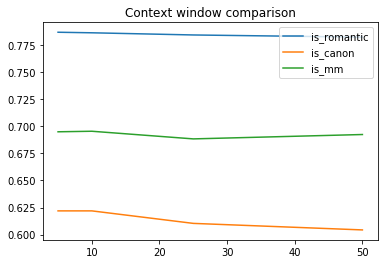

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.title('Context window comparison')
for key in predictions:
    values = [results[cw][key] for cw in feature_sets]
    plt.plot([int(f.split('_')[-1]) for f in feature_sets], values, label=key)

plt.legend()

In [29]:
import numpy as np

for feature_set in feature_sets:
    avg = np.mean([results[feature_set][pred] for pred in predictions])
    print(f"{feature_set}: {avg}")

pairing_embedding_unigrams_assertions_local_5: 0.7011118482636219
pairing_embedding_unigrams_assertions_local_10: 0.7011110044138104
pairing_embedding_unigrams_assertions_local_25: 0.6942500306477157
pairing_embedding_unigrams_assertions_local_50: 0.6929188279611349


# See how much data require for unigrams with local context 10 to converge

In [5]:
# Load dev
import pandas as pd

dev = pd.read_pickle('/usr2/mamille2/fanfiction-project/data/features/relationship_prediction_assertion_dev.pkl')
print(dev.columns)
len(dev)

Index(['fic_id', 'pairing', 'pairing_embedding_unigrams_assertions_local',
       'relationship', 'selected_relationships', 'is_romantic', 'is_canon',
       'is_mm'],
      dtype='object')


5903

In [21]:
# Filter out any rows with inconsistent embedding shapes

dev['shape'] = dev['pairing_embedding_unigrams_assertions_local'].map(lambda x: x.shape)
dev = dev[dev['shape'] == (1, 134240)]
len(dev)

5902

In [27]:
from IPython.core.debugger import set_trace

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import scipy

train, test = train_test_split(dev, test_size=0.1, random_state=9)
print(len(train))
print(len(test))

feature_set = 'unigrams_assertions_local'

X_test, y_test = {}, {}
X_test[feature_set] = scipy.sparse.vstack(test[f'pairing_embedding_{feature_set}'].tolist())
y_test['is_romantic'] = test['is_romantic'].tolist()
y_test['is_canon'] = test['is_canon'].tolist()
y_test['is_mm'] = test['is_mm'].tolist()

5311
591


In [46]:
results = {}

for nrows in [500, 1000, 1200, 1500, 2000, 4000, 5311]:
    results[nrows] = {}
    sample = train.sample(nrows)
    y_train = {}

    X_train = scipy.sparse.vstack(sample[f'pairing_embedding_{feature_set}'].tolist())
        
    y_train['is_romantic'] = sample['is_romantic'].tolist()
    y_train['is_canon'] = sample['is_canon'].tolist()
    y_train['is_mm'] = sample['is_mm'].tolist()
    
    for key in ['is_romantic', 'is_canon', 'is_mm']:
        clf = LogisticRegression()
        clf.fit(X_train, y_train[key])
        results[nrows][key] = clf.score(X_test[feature_set], y_test[key])
        print(f'{nrows}\t{key}: {results[nrows][key]}')

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


500	is_romantic: 0.7834179357021996
500	is_canon: 0.6717428087986463
500	is_mm: 0.6175972927241963
1000	is_romantic: 0.8071065989847716
1000	is_canon: 0.6852791878172588
1000	is_mm: 0.6598984771573604
1200	is_romantic: 0.8138747884940778
1200	is_canon: 0.6903553299492385
1200	is_mm: 0.6582064297800339
1500	is_romantic: 0.8087986463620981
1500	is_canon: 0.6954314720812182
1500	is_mm: 0.6632825719120136
2000	is_romantic: 0.8155668358714044
2000	is_canon: 0.6954314720812182
2000	is_mm: 0.6785109983079526
4000	is_romantic: 0.8257191201353637
4000	is_canon: 0.6920473773265652
4000	is_mm: 0.6734348561759729
5311	is_romantic: 0.8307952622673435
5311	is_canon: 0.7072758037225042
5311	is_mm: 0.6734348561759729


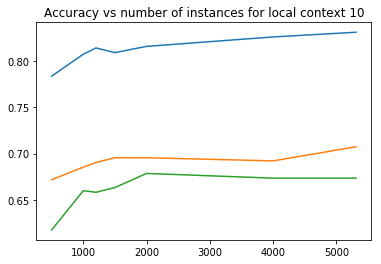

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.title('Accuracy vs number of instances for local context 10')
for key in y_test:
    plt.plot(results.keys(), [results[nrows][key] for nrows in results.keys()])

# Build dev set, sample5400, figure out how much data have processed

In [1]:
import pandas as pd

# data = pd.read_pickle('/usr0/home/mamille2/erebor/fanfiction-project/data/features/relationship_prediction_sample6k.pkl')
data = pd.read_pickle('/usr2/mamille2/fanfiction-project/data/features/relationship_prediction_6k_assertion_local_ngrams1.pkl')
print(data.columns)
print(len(data))

Index(['fic_id', 'pairing', 'pairing_embedding_unigrams_assertions_local_5',
       'pairing_embedding_unigrams_assertions_local_10',
       'pairing_embedding_unigrams_assertions_local_25',
       'pairing_embedding_unigrams_assertions_local_50', 'relationship',
       'selected_relationships', 'is_romantic', 'is_canon', 'is_mm'],
      dtype='object')
11903


In [2]:
# Read in fic_ids where have pipeline assertions
import os

# pipeline_output_dirpath = '/usr0/home/mamille2/erebor/fanfiction-project/data/ao3/harrypotter/emnlp_dataset_6k/output'
pipeline_output_dirpath = '/usr2/mamille2/fanfiction-project/data/ao3/harrypotter/emnlp_dataset_6k/output'
fic_ids_processed = [int(fname.split('.')[0]) for fname in os.listdir(os.path.join(pipeline_output_dirpath, 'char_coref_chars'))]
len(fic_ids_processed)

5275

In [3]:
processed_data = data[data['fic_id'].isin(fic_ids_processed)]
print(len(processed_data))

11903

In [5]:
processed_data.iloc[0]['pairing_embedding_unigrams_assertions_local_10'].shape

(1, 170998)

In [7]:
# Remove rows with inconsistent sizes
for cw in [10]:
    processed_data[f'shape_{cw}'] = processed_data[f'pairing_embedding_unigrams_assertions_local_{cw}'].map(
            lambda x: x.shape)
    
processed_data =processed_data[processed_data['shape_10'] == (1, 170998)]
len(processed_data)

11900

In [8]:
# Pairing distribution
pairing_counts = processed_data['pairing'].value_counts().to_dict()
pairing_counts

{('harry', 'hermione'): 2616,
 ('harry', 'ron'): 2371,
 ('draco', 'harry'): 2249,
 ('hermione', 'ron'): 2084,
 ('draco', 'hermione'): 1349,
 ('ginny', 'harry'): 1231}

In [9]:
# Take dev set out to make rest of the data even among pairs
dev = pd.DataFrame(columns=processed_data.columns)

for pairing in pairing_counts:
    
    n_sample = pairing_counts[pairing] - 900
    pairing_rows = processed_data[processed_data['pairing']==pairing].sample(n_sample)

    dev = pd.concat([dev, pairing_rows])
    
print(len(dev))
dev.head()

6500


,fic_id,pairing,pairing_embedding_unigrams_assertions_local_5,pairing_embedding_unigrams_assertions_local_10,pairing_embedding_unigrams_assertions_local_25,pairing_embedding_unigrams_assertions_local_50,relationship,selected_relationships,is_romantic,is_canon,is_mm,shape_10
976,10787391,"(harry, hermione)","(0, 31261)\t0.3065821297016981\n (0, 54196)...","(0, 83634)\t0.05724316226477776\n (0, 31261...","(0, 50239)\t0.028285831094124712\n (0, 8363...","(0, 50239)\t0.023652065913054812\n (0, 8363...",[],[],False,True,False,"(1, 170998)"
10641,8156495,"(harry, hermione)","(0, 66184)\t0.08009916993796581\n (0, 83634...","(0, 66184)\t0.04376448533703871\n (0, 16668...","(0, 66184)\t0.023168273542914713\n (0, 5606...","(0, 66184)\t0.015047092471738154\n (0, 5606...","[""Sirius Black/Hermione Granger"", ""Harry Potte...","[(ginny, harry)]",False,True,False,"(1, 170998)"
1617,1133309,"(harry, hermione)","(0, 16668)\t0.023128938517985014\n (0, 8363...","(0, 50239)\t0.022655109110651873\n (0, 1666...","(0, 5621)\t0.00814044491185028\n (0, 50239)...","(0, 5621)\t0.011490005748049346\n (0, 50239...","[""Harry Potter/Severus Snape""]",[],False,True,False,"(1, 170998)"
8062,48288,"(harry, hermione)","(0, 64384)\t0.09873391641610021\n (0, 12898...","(0, 16668)\t0.040331877604220336\n (0, 6438...","(0, 16668)\t0.021473141847259136\n (0, 1465...","(0, 16668)\t0.015889207758698783\n (0, 8363...","[""Harry Potter/Ginny Weasley""]","[(ginny, harry)]",False,True,False,"(1, 170998)"
557,1025930,"(harry, hermione)","(0, 63778)\t0.2218424330278441\n (0, 81806)...","(0, 63778)\t0.15287154393840818\n (0, 81806...","(0, 16668)\t0.05061929585737284\n (0, 63778...","(0, 16668)\t0.040959733281774796\n (0, 6377...","[""Harry Potter/Severus Snape""]",[],False,True,False,"(1, 170998)"


In [10]:
nondev_data = processed_data[~processed_data.index.isin(dev.index)]
print(len(nondev_data))
nondev_data['pairing'].value_counts()

5400


(draco, hermione)    900
(harry, ron)         900
(ginny, harry)       900
(harry, hermione)    900
(hermione, ron)      900
(draco, harry)       900
Name: pairing, dtype: int64

In [71]:
dev['pairing'].value_counts()

(harry, hermione)    1717
(harry, ron)         1471
(draco, harry)       1349
(hermione, ron)      1185
(draco, hermione)     449
(ginny, harry)        332
Name: pairing, dtype: int64

In [11]:
# Save
nondev_data.to_pickle(f'/usr2/mamille2/fanfiction-project/data/features/relationship_prediction_assertion_sample{len(nondev_data)}.pkl')
dev.to_pickle('/usr2/mamille2/fanfiction-project/data/features/relationship_prediction_assertion_dev.pkl')